In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import copy
import matplotlib as mpl
from matplotlib.colors import ListedColormap ,LinearSegmentedColormap, to_rgba
import matplotlib.patches as patches
import os
import scipy.linalg as sclinalg

(array([496., 302.,   0.,   0., 167.,   0.,   0.,   0.,   0.,  36.]),
 array([0.06 , 0.134, 0.208, 0.282, 0.356, 0.43 , 0.504, 0.578, 0.652,
        0.726, 0.8  ]),
 <a list of 10 Patch objects>)

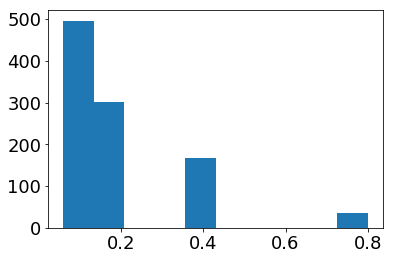

In [15]:
numpoints = 1001
albedo_map = np.loadtxt('albedos/albedo_map1_n'+str(numpoints)+'.txt',delimiter=',')

voronoi_grid = np.loadtxt('voronoi_grid_n'+str(numpoints),delimiter=',')
plot_facets_vor = np.load('plot_facets_n'+str(numpoints)+'.npy',allow_pickle=',')
phi_grid,theta_grid,area_grid = voronoi_grid.transpose()
plt.hist(albedo_map)

In [16]:
%%time
'''
Parameters
'''
res = len(phi_grid)
rho = 6.371e6
R = 1.496e11
alpha = 0/180*np.pi
beta = 30/180*np.pi

day = 24
year = 365*day
omega_day = 2*np.pi/day
omega_year = 2*np.pi/year


delta_t = 1
hours = np.arange(0,24)
time_array = np.array([])

N_ave = 187

time_array = np.linspace(0,year,2000) #a number of time measurements spread evenly throughout a year
filename = 'f_curves/edge_t'+str(len(time_array))+'.npy'

# for i in range(200): #every hour for a whole year of 365 days
#     time_array = np.append(time_array,hours+i*year/200)

# for i in range(8): #8 days spread out throughout the year 128 images taken over a couple of hours
#     time_array = np.append(time_array,np.linspace(0,2,2**7) + i*year/8)
# filename = 'f_curves/edge_tburst2h_'+str(len(time_array))+'.txt' #burst measurements, 2hours

time_res = len(time_array)
# '''
# Albedo-map
# '''
# A = np.ones(res)
# time = np.linspace(0,1,round(year/delta_t))*365


'''
Euler rotation matrices
'''
def positive(arg):
    return(arg+abs(arg))/2

def y_rotation(angle):
    Y = np.array([[np.cos(angle),0,np.sin(angle)],[0,1,0],
                  [-np.sin(angle),0,np.cos(angle)]])
    return Y

def z_rotation(angle):
    Z = np.array([[np.cos(angle),-np.sin(angle),0],
                  [np.sin(angle),np.cos(angle),0],[0,0,1]])
    return Z



R_equinox = z_rotation(alpha)
R_tilt = y_rotation(beta)
R_axial = np.matmul(R_equinox,R_tilt)


'''
Initialize transfromation matrices (edge-on, face-on)
'''
T = np.zeros((time_res,res))

T1 = T.copy()

'''
Observer
'''
o_vec = np.array([1,0,0]) #gamma = pi/2; edge-on
o_vec_1 = np.array([0,0,1]) #gamma = 0; face-on


'''
Compute matrix elements
'''
for i in range(len(time_array)):
    t = time_array[i]
    r_vec = np.array([-np.cos(omega_year*t),-np.sin(omega_year*t),0])
    R_daily = z_rotation(omega_day*t)
    daily_rotation = np.matmul(R_axial,R_daily)

    for j in range(res):
        phi = phi_grid[j]
        theta = theta_grid[j]
        s_vec = np.array([np.cos(phi)*np.sin(theta),
                          np.sin(phi)*np.sin(theta),np.cos(theta)])
        s_vec_rotated = np.matmul(daily_rotation,s_vec)

        r_s = np.dot(r_vec,s_vec_rotated)
        s_o = np.dot(s_vec_rotated,o_vec)
        s_o_1 = np.dot(s_vec_rotated,o_vec_1)


        illuminated = positive(r_s)
        visible = positive(s_o)
        visible_1 = positive(s_o_1)

        T[i][j] = illuminated*visible*np.sin(theta)*area_grid[j] 
        T1[i][j] = illuminated*visible_1*np.sin(theta)*area_grid[j]  
        #area_grid is calculated for a sphere with radius 1, so for small faces, the angles are small, so \Delta\phi*\Delta\theta = area_grid
print('size: ',T.shape)
print('rank: ',np.linalg.matrix_rank(T))

size:  (2000, 1001)
rank:  934
Wall time: 1min 50s


In [17]:
'''
Compute light-curves
'''
c_light = rho**2/(R**2*np.pi)
f_curve_edge = np.matmul(T,albedo_map)*c_light
f_curve_face = np.matmul(T1,albedo_map)*c_light

noise_poisson = np.random.poisson(N_ave,time_res)/N_ave
noise_gauss = np.random.normal(0,1,time_res)

#f_curve_edge_noisy = f_curve_edge+noise_gauss*max(f_curve_edge)/100
#f_curve_face_noisy = f_curve_face+noise_gauss*max(f_curve_face)/100

f_curve_edge_noisy = np.multiply(f_curve_edge,noise_poisson)
f_curve_face_noisy = np.multiply(f_curve_face,noise_poisson)

os.makedirs(os.path.dirname(filename), exist_ok=True)
f_curve_time = [f_curve_edge,time_array]
np.save(filename,f_curve_time,allow_pickle=True)

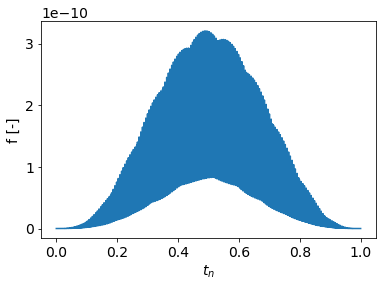

2000


In [18]:
mpl.rcParams.update({'font.size': 14})
plt.plot(time_array/year,f_curve_edge)
# plt.plot(time_array/year,f_curve_edge_noisy,alpha=0.5)
plt.xlabel('$t_n$')
plt.ylabel('f [-]')
# plt.plot(f_curve_face,linewidth=0.1)
# plt.plot(f_curve_face_noisy,linewidth=0.1)

plt.show()
print(len(f_curve_edge))

In [19]:
%%time
'''
Save transfer matrices for later use
'''
#np.savez_compressed('Albedo_a90_b90_20d_res_15.npz',edge = T,face = T1)


'''
Compute and save SVD
'''
# SVD_edge = np.linalg.svd(T,compute_uv = False)
# SVD_face = np.linalg.svd(T1,compute_uv = False)
'''
Compute inverse transfer matrix
'''
T_pinv_edge = np.linalg.pinv(T,rcond = 10e-9)
T_pinv_face = np.linalg.pinv(T1,rcond = 10e-9)
A_edge = np.matmul(T_pinv_edge,f_curve_edge)/c_light
A_face = np.matmul(T_pinv_face,f_curve_face)/c_light
# scale the matrix A such that the smallest value is 0 and the highest is 0.8
A_edge_scaled = 0.8*(A_edge-min(A_edge))/(max(A_edge)-min(A_edge))
A_face_scaled = 0.8*(A_face-min(A_face))/(max(A_face)-min(A_face))

#round the albedo values to the available discrete values of the used surfaces
#simultaneously assign the right color to the point for the plot later
gist_earth = mpl.cm.get_cmap('gist_earth',4000) #colors
colors = np.array([gist_earth(0.05),gist_earth(0.36),gist_earth(0.8),to_rgba('white')])
albedos = np.array([0.06,0.15,0.4,0.8])

def round_albedo(unrounded,albedos,colors):
    idx = np.argmin(np.abs(unrounded-albedos[:,np.newaxis]),axis=0)
    return albedos[idx], colors[idx]

albedo_edge, edge_colors = round_albedo(A_edge,albedos,colors)
albedo_face, face_colors = round_albedo(A_face,albedos,colors)
albedo_edge_scaled, edge_colors_scaled = round_albedo(A_edge_scaled,albedos,colors)
albedo_face_scaled, face_colors_scaled = round_albedo(A_face_scaled,albedos,colors)
trash, albedo_colors = round_albedo(albedo_map,albedos,colors)

Wall time: 3.09 s


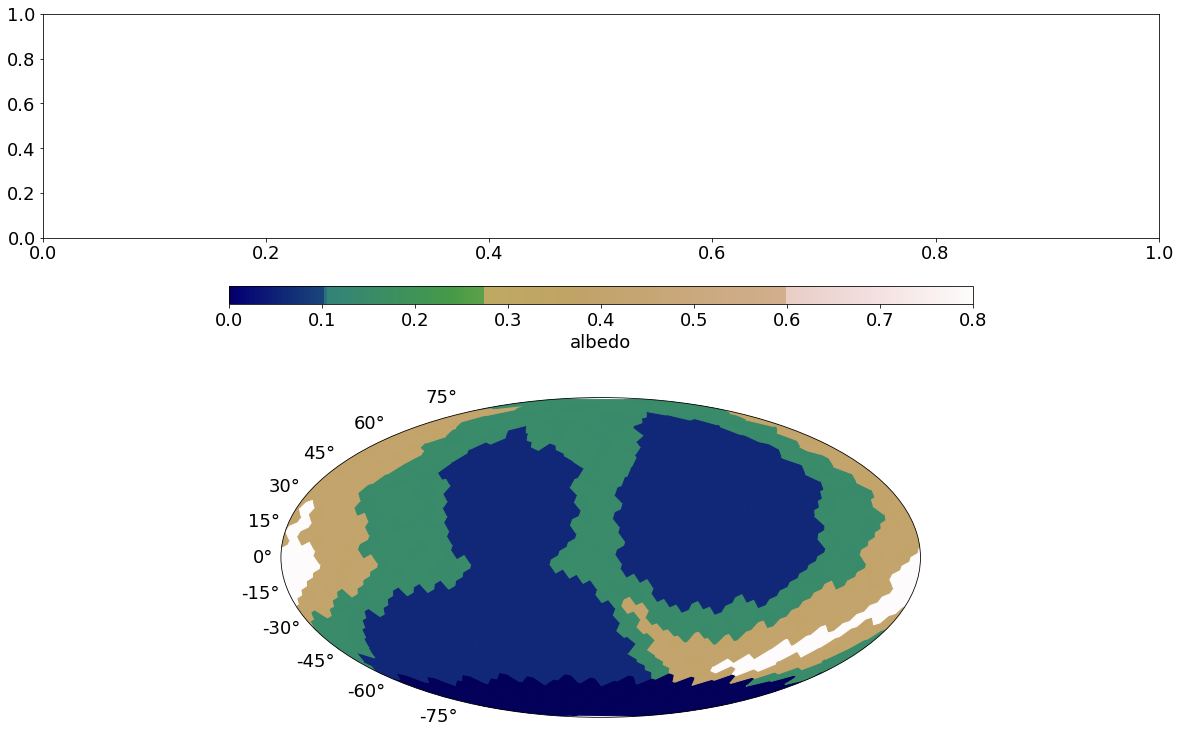

Wall time: 6.5 s


In [23]:
%%time
alts = copy.copy(A_edge)
alts = alts-np.mean(alts)
max_alt = max(alts)
min_alt = min(alts)
norm_alts = (alts-min_alt)/(max_alt-min_alt)

snowheight = 0.8
soilheight = 0.4


hsv=mpl.cm.get_cmap('hsv',4000)
N = 256
y1 = gist_earth(np.linspace(0.02,0.15,int(N/2))) #ocean colors, for half the heights
y2 = gist_earth(np.linspace(0.3,0.5,int(N/2*soilheight))) #forest colors
y3 = gist_earth(np.linspace(0.7,0.82,int(N/2*(snowheight-soilheight)))) #soil colors
y4 = gist_earth(np.linspace(0.93,1,int(N/2*(1-snowheight)))) #snow colors

y = np.vstack((y1,y2,y3,y4))

cmap = LinearSegmentedColormap.from_list('custom earth', y, N=256)

y1 = gist_earth(np.linspace(0.02,0.15,int(N*(albedos[1]+albedos[0])))) #ocean colors, for half the heights
y2 = gist_earth(np.linspace(0.3,0.5,int(N*(albedos[2]-albedos[0])))) #forest colors
y3 = gist_earth(np.linspace(0.76,0.85,int(N*(albedos[3]-albedos[1])))) #soil colors
y4 = gist_earth(np.linspace(0.93,1,int(N*(0.8-albedos[2])))) #snow colors

y = np.vstack((y1,y2,y3,y4))

cmap_albedo = LinearSegmentedColormap.from_list('custom earth', y, N=256)

mpl.rcParams.update({'font.size': 18})

fig = plt.figure(figsize = [20,20])
ax = fig.add_subplot(311)
ax2 = fig.add_subplot(312,projection='mollweide')
# ax3 = fig.add_subplot(313,projection='mollweide')


norm = mpl.colors.Normalize(vmin=0, vmax=0.8)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap_albedo)
cmapplot.set_array([])
fig.colorbar(cmapplot, ax=ax, orientation='horizontal', label='albedo',shrink=1/1.5,aspect=40)

i=0
for facet_sph in plot_facets_vor:
    plot_facet = copy.copy(facet_sph)
    plot_facet[:,1] = -plot_facet[:,1]
    c = cmap_albedo(A_edge[i]/0.8)
    if np.any(plot_facet[:,0]>np.pi):
        ax2.add_patch(patches.Polygon(plot_facet, fill = True, color = c))
        temp_facet = copy.copy(plot_facet)
        temp_facet[:,0] += -2*np.pi
        ax2.add_patch(patches.Polygon(temp_facet, fill = True, color = c))
    elif np.any(plot_facet[:,0]<-np.pi):
        ax2.add_patch(patches.Polygon(plot_facet, fill = True, color = c))
        temp_facet = copy.copy(plot_facet)
        temp_facet[:,0] += 2*np.pi
        ax2.add_patch(patches.Polygon(temp_facet, fill = True, color = c))
    else:
        ax2.add_patch(patches.Polygon(plot_facet, fill = True, color = c))
    i+=1

# i=0
# for facet_sph in plot_facets_vor:
#     c = cmap_albedo(albedo_map[i]/0.8)
#     plot_facet = copy.copy(facet_sph)
#     plot_facet[:,1] = -plot_facet[:,1] #flip vertically
#     if np.any(facet_sph[:,0]>np.pi):
#         ax3.add_patch(patches.Polygon(plot_facet, fill = True, color = c))
#         facet_sph[:,0] += -2*np.pi
#         ax3.add_patch(patches.Polygon(plot_facet, fill = True, color = c))
#     elif np.any(facet_sph[:,0]<-np.pi):
#         ax3.add_patch(patches.Polygon(plot_facet, fill = True, color = c))
#         facet_sph[:,0] += 2*np.pi
#         ax3.add_patch(patches.Polygon(plot_facet, fill = True, color = c))
#     else:
#         ax3.add_patch(patches.Polygon(plot_facet, fill = True, color = c))
#     i+=1
filename = 'retrieved_albedo/edgeretr1_n'+str(res)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove x-ticks
# ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
# filename = 'albedos/seed1'
plt.savefig(filename)
plt.show()

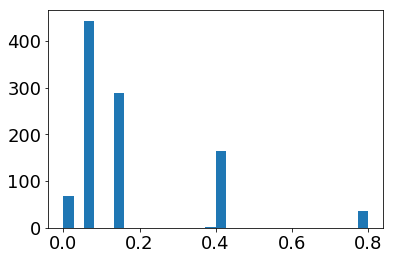

In [24]:
plt.hist(A_edge,bins=30)
plt.show()